# Analysis of Election Result

Problem Statement:

You are hired by one of the leading news channels CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.

In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from scipy.stats import chi2_contingency,zscore
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,roc_curve,classification_report,plot_confusion_matrix

In [399]:
def q1_q3(x):
    q1,q3=x.quantile([0.25,0.75])
    iqr=q3-q1
    
    upper_limit=q3+(1.5*iqr)
    lower_limit=q1-(1.5*iqr)
    
    return (x < lower_limit).sum(),(x > upper_limit).sum()

## Data Dictionary

In [400]:
pd.read_excel('Election_Data.xlsx',index_col=0)

Empty DataFrame
Columns: []
Index: [1. vote: Party choice: Conservative or Labour, 2. age: in years, 3. economic.cond.national: Assessment of current national economic conditions, 1 to 5., 4. economic.cond.household: Assessment of current household economic conditions, 1 to 5., 5. Blair: Assessment of the Labour leader, 1 to 5., 6. Hague: Assessment of the Conservative leader, 1 to 5., 7. Europe: an 11-point scale that measures respondents' attitudes toward European integration. High scores represent ‘Eurosceptic’ sentiment., 8. political.knowledge: Knowledge of parties' positions on European integration, 0 to 3., 9. gender: female or male.]

## Data Summary

In [401]:
data=pd.read_excel('Election_Data.xlsx',sheet_name='Election_Dataset_Two Classes',index_col=0)
election=data.copy()
election.head()

vote  age  economic.cond.national  economic.cond.household  Blair  Hague  Europe  political.knowledge  gender
1  Labour   43                       3                        3      4      1       2                    2  female
2  Labour   36                       4                        4      4      4       5                    2    male
3  Labour   35                       4                        4      5      2       3                    2    male
4  Labour   24                       4                        2      2      1       4                    0  female
5  Labour   41                       2                        2      1      1       6                    2    male

In [402]:
election.columns=election.columns.str.replace('.','_')
election.head()

vote  age  economic_cond_national  economic_cond_household  Blair  Hague  Europe  political_knowledge  gender
1  Labour   43                       3                        3      4      1       2                    2  female
2  Labour   36                       4                        4      4      4       5                    2    male
3  Labour   35                       4                        4      5      2       3                    2    male
4  Labour   24                       4                        2      2      1       4                    0  female
5  Labour   41                       2                        2      1      1       6                    2    male

In [403]:
election.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1525 entries, 1 to 1525
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic_cond_national   1525 non-null   int64 
 3   economic_cond_household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political_knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 119.1+ KB


In [404]:
election.describe()

age  economic_cond_national  economic_cond_household  ...        Hague       Europe  political_knowledge
count  1525.000000             1525.000000              1525.000000  ...  1525.000000  1525.000000          1525.000000
mean     54.182295                3.245902                 3.140328  ...     2.746885     6.728525             1.542295
std      15.711209                0.880969                 0.929951  ...     1.230703     3.297538             1.083315
min      24.000000                1.000000                 1.000000  ...     1.000000     1.000000             0.000000
25%      41.000000                3.000000                 3.000000  ...     2.000000     4.000000             0.000000
50%      53.000000                3.000000                 3.000000  ...     2.000000     6.000000             2.000000
75%      67.000000                4.000000                 4.000000  ...     4.000000    10.000000             2.000000
max      93.000000                5.000000                 5.000000  ...     5.000000    11.000000             3.000000

[8 rows x 7 columns]

## Removal of duplicates

In [405]:
election.duplicated().sum()

8

In [406]:
election[election.duplicated(keep=False)]

vote  age  economic_cond_national  economic_cond_household  ...  Hague  Europe  political_knowledge  gender
3           Labour   35                       4                        4  ...      2       3                    2    male
68          Labour   35                       4                        4  ...      2       3                    2    male
87    Conservative   53                       3                        4  ...      2       6                    0  female
334         Labour   38                       2                        4  ...      2       4                    3    male
391         Labour   39                       3                        4  ...      2       5                    2    male
578   Conservative   74                       4                        3  ...      4       8                    2  female
627         Labour   39                       3                        4  ...      2       5                    2    male
871         Labour   38                       2                        4  ...      2       4                    3    male
917         Labour   29                       4                        4  ...      2       2                    2  female
984   Conservative   74                       4                        3  ...      4       8                    2  female
1038        Labour   40                       4                        3  ...      2       2                    2    male
1155  Conservative   53                       3                        4  ...      2       6                    0  female
1210        Labour   36                       3                        3  ...      2       6                    2  female
1237        Labour   36                       3                        3  ...      2       6                    2  female
1245        Labour   29                       4                        4  ...      2       2                    2  female
1439        Labour   40                       4                        3  ...      2       2                    2    male

[16 rows x 9 columns]

In [407]:
election.drop_duplicates(keep='first',inplace=True)
election.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 1 to 1525
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1517 non-null   object
 1   age                      1517 non-null   int64 
 2   economic_cond_national   1517 non-null   int64 
 3   economic_cond_household  1517 non-null   int64 
 4   Blair                    1517 non-null   int64 
 5   Hague                    1517 non-null   int64 
 6   Europe                   1517 non-null   int64 
 7   political_knowledge      1517 non-null   int64 
 8   gender                   1517 non-null   object
dtypes: int64(7), object(2)
memory usage: 118.5+ KB


## Outliers summary

In [408]:
cols=election.dtypes[election.dtypes=='int64'].index
election[cols].apply(q1_q3,axis=0).T.rename(columns={0:'Lower_range',1:'Upper range'})

Lower_range  Upper range
age                                0            0
economic_cond_national            37            0
economic_cond_household           65            0
Blair                              0            0
Hague                              0            0
Europe                             0            0
political_knowledge                0            0

## EDA

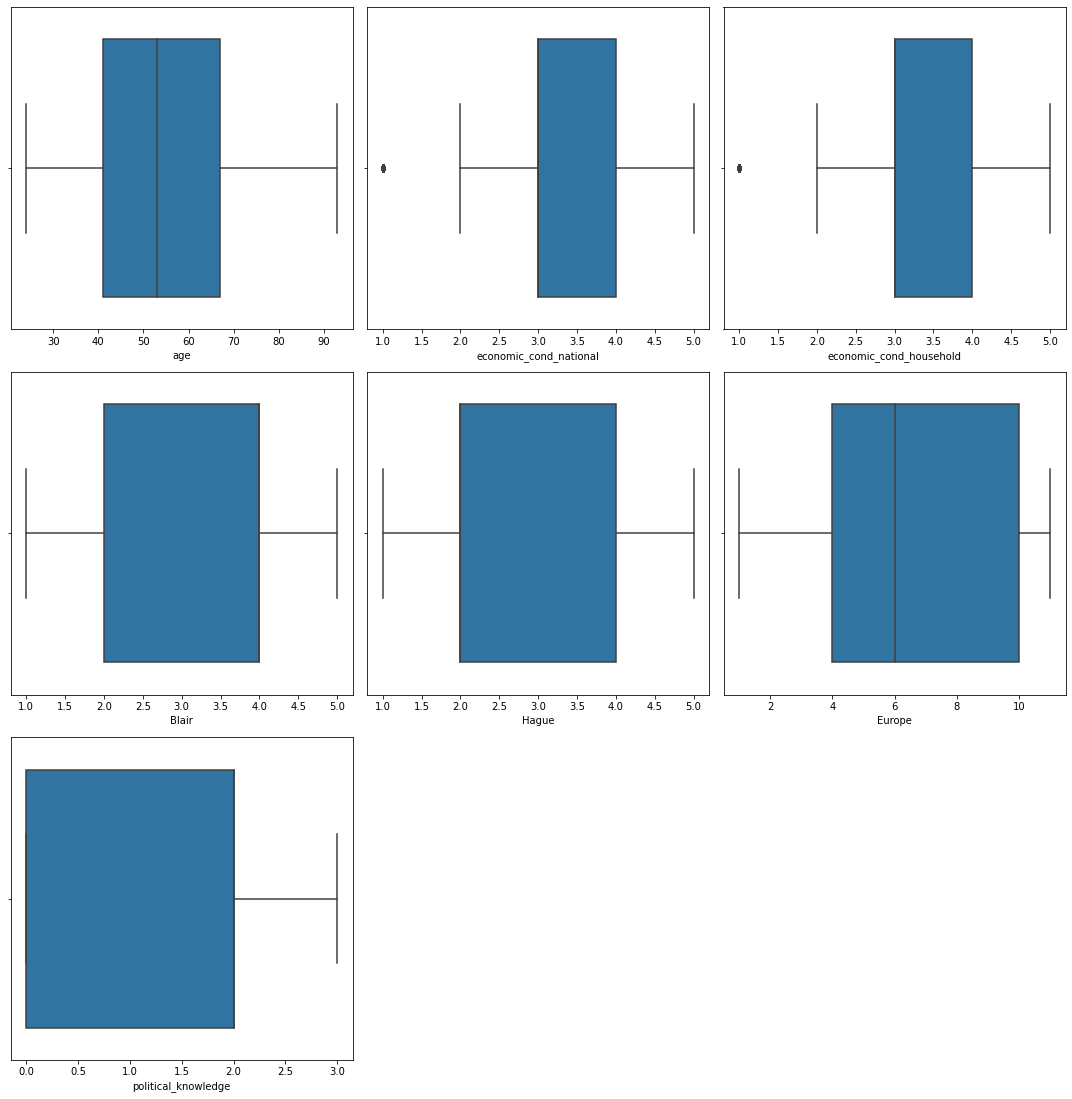

In [409]:
plt.figure(figsize=(15,20))
for idx,col in enumerate(cols):
    plt.subplot(len(cols)-3,3,idx+1)
    sns.boxplot(x=election[col])
    plt.tight_layout()

In [410]:
election.skew()

age                        0.139800
economic_cond_national    -0.238474
economic_cond_household   -0.144148
Blair                     -0.539514
Hague                      0.146191
Europe                    -0.141891
political_knowledge       -0.422928
dtype: float64

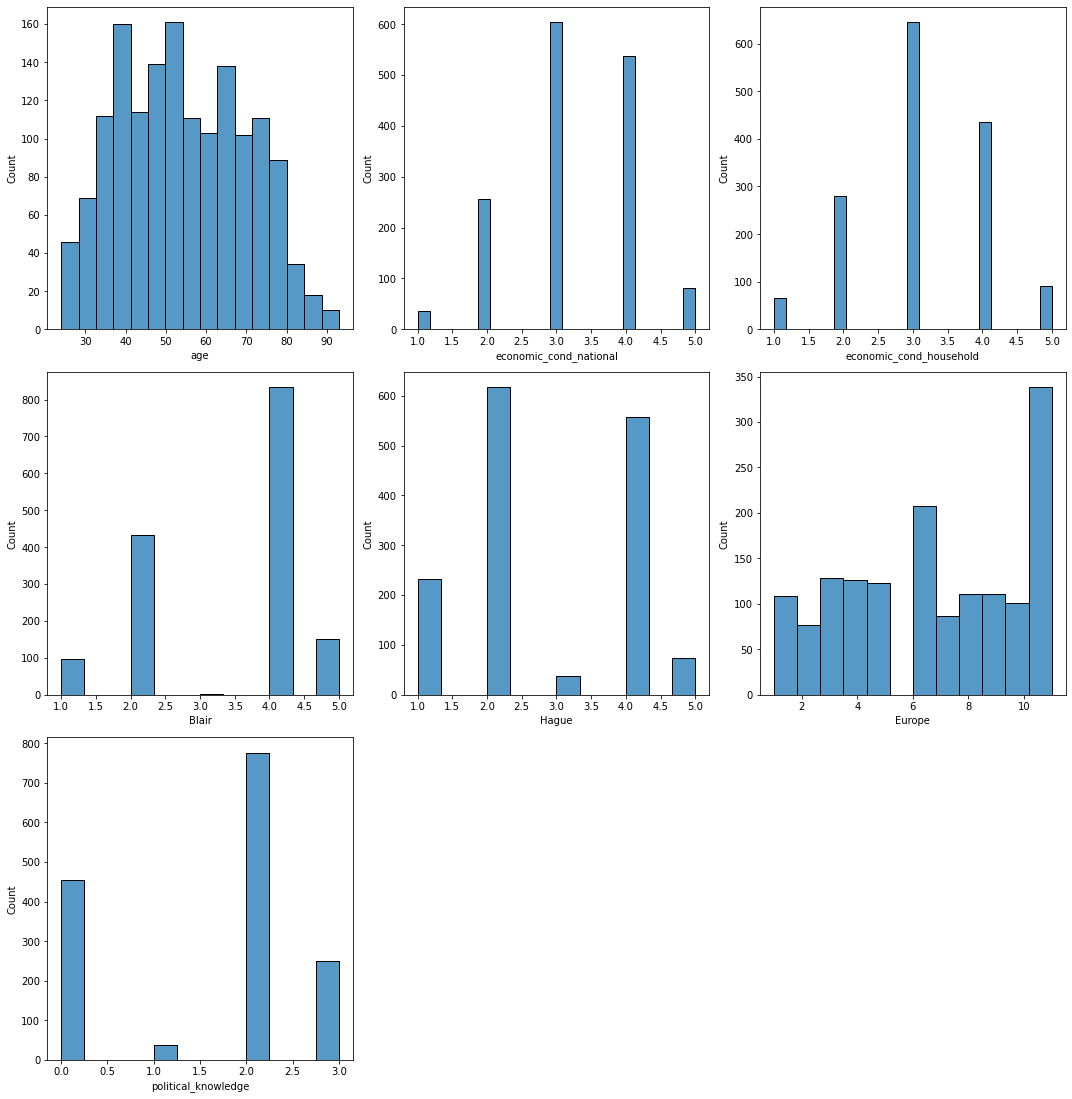

In [411]:
plt.figure(figsize=(15,20))
for idx,col in enumerate(cols):
    plt.subplot(len(cols)-3,3,idx+1)
    sns.histplot(x=election[col])
    plt.tight_layout()

In [412]:
election.vote.value_counts(normalize=True) *100

Labour          69.676994
Conservative    30.323006
Name: vote, dtype: float64

In [413]:
election.gender.value_counts(normalize=True) *100

female    53.263019
male      46.736981
Name: gender, dtype: float64

Text(0.5, 1.0, 'Age vs Party')

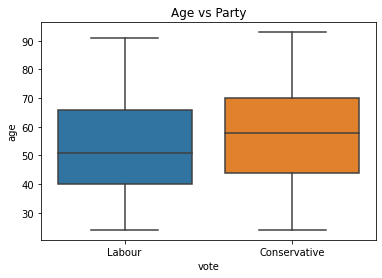

In [414]:
sns.boxplot(x=election.vote,y=election.age)
plt.title('Age vs Party')

Text(0.5, 1.0, 'Gender vs Party')

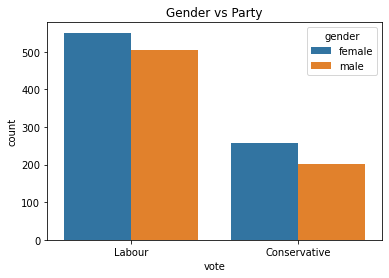

In [415]:
sns.countplot(hue='gender',x='vote',data=election)
plt.title('Gender vs Party')

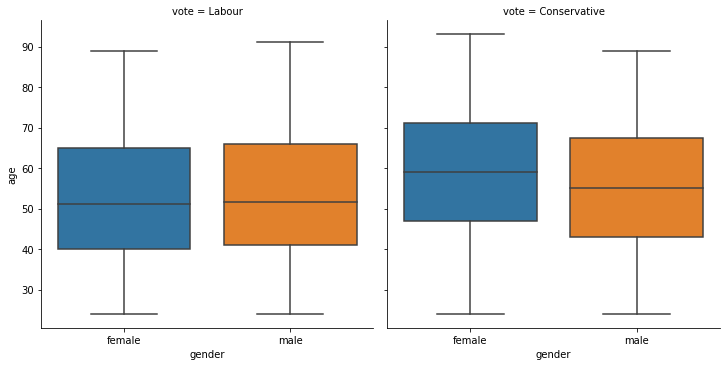

In [416]:
sns.catplot(col='vote',y='age',x='gender',data=election,kind='box')

Text(0.5, 1.0, 'Economic Condition vs Party')

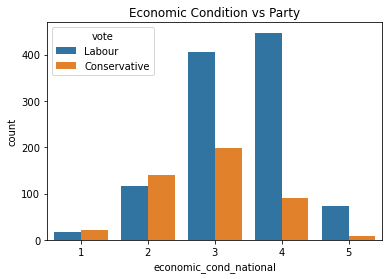

In [417]:
sns.countplot(x=election.economic_cond_national,hue=election.vote)
plt.title('Economic Condition vs Party')

People with eco.codition <2 are voting to Conservative

Text(0.5, 1.0, 'Economic Condition Household vs Party')

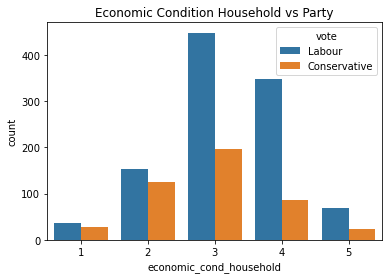

In [418]:
sns.countplot(x=election.economic_cond_household,hue=election.vote)
plt.title('Economic Condition Household vs Party')

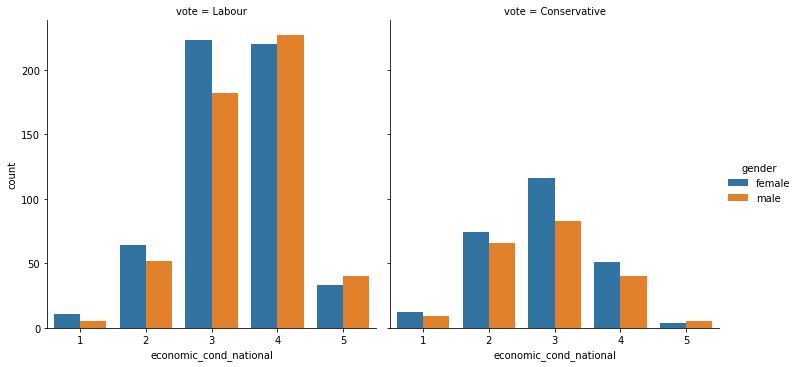

In [419]:
sns.catplot(x='economic_cond_national',hue='gender',kind='count',data=election,col='vote')

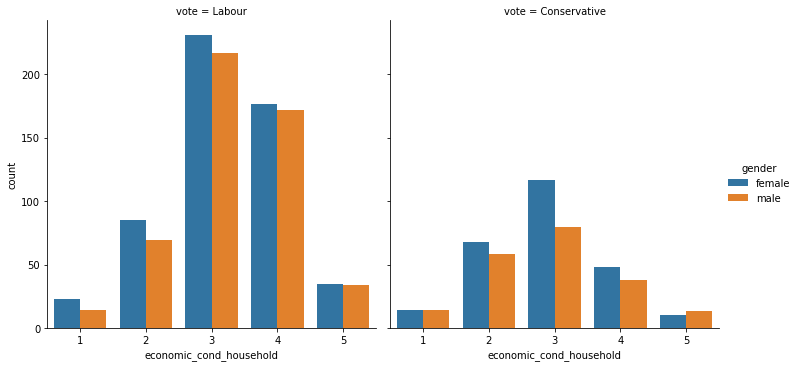

In [420]:
sns.catplot(x='economic_cond_household',hue='gender',kind='count',data=election,col='vote')

Text(0.5, 1.0, 'People Evaluated Blair')

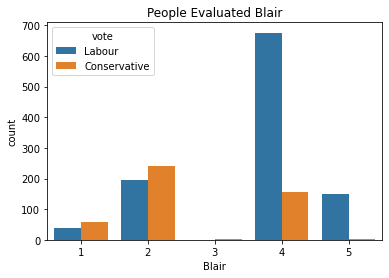

In [421]:
sns.countplot(data=election,x='Blair',hue='vote')
plt.title('People Evaluated Blair')

Text(0.5, 1.0, 'People Evaluated Hague')

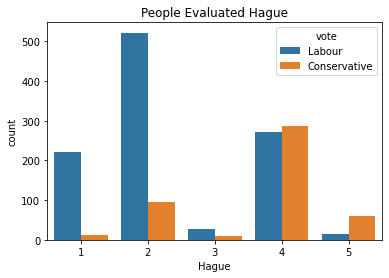

In [422]:
sns.countplot(data=election,x='Hague',hue='vote')
plt.title('People Evaluated Hague')

Text(0.5, 1.0, 'Europe Knowledge on Voting')

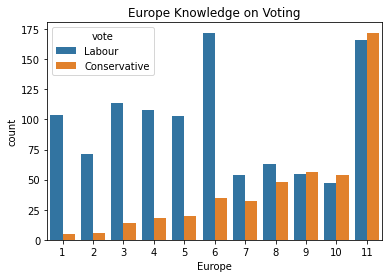

In [423]:
sns.countplot(data=election,hue='vote',x='Europe')
plt.title('Europe Knowledge on Voting')

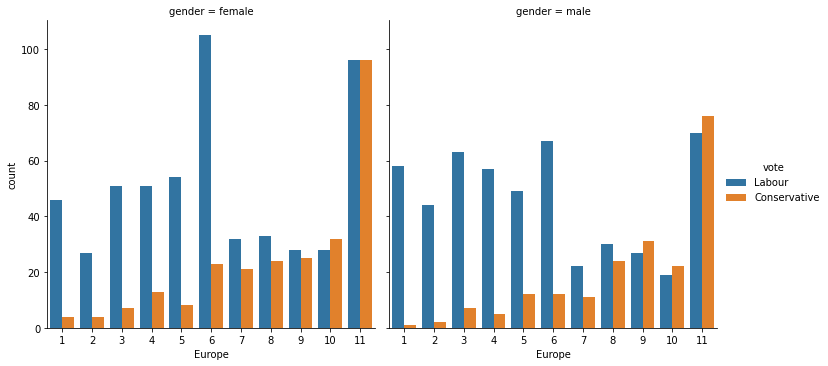

In [424]:
sns.catplot(data=election,x='Europe',kind='count',hue='vote',col='gender')

Text(0.5, 1.0, 'Political knowledge vs Party')

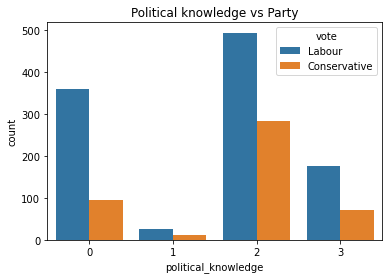

In [425]:
sns.countplot(data=election,x='political_knowledge',hue='vote')
plt.title('Political knowledge vs Party')

Text(0.5, 1.0, 'Political knowledge based on gender')

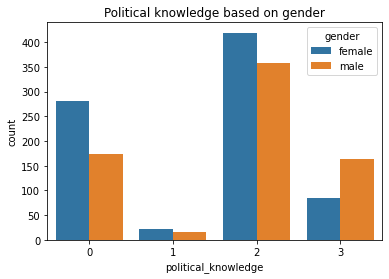

In [426]:
sns.countplot(data=election,x='political_knowledge',hue='gender')
plt.title('Political knowledge based on gender')

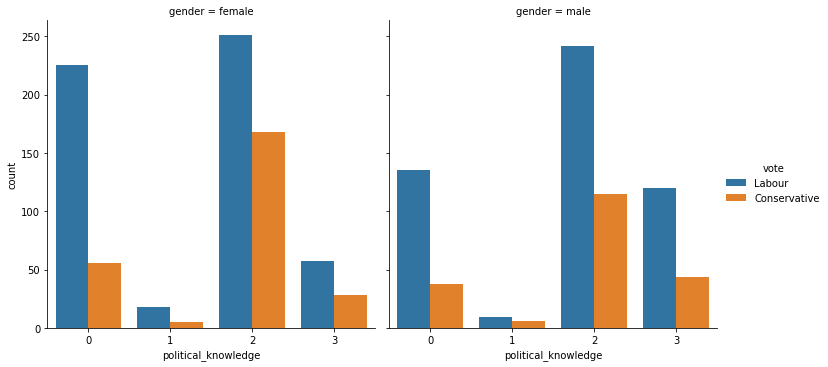

In [427]:
sns.catplot(data=election,x='political_knowledge',col='gender',hue='vote',kind='count')

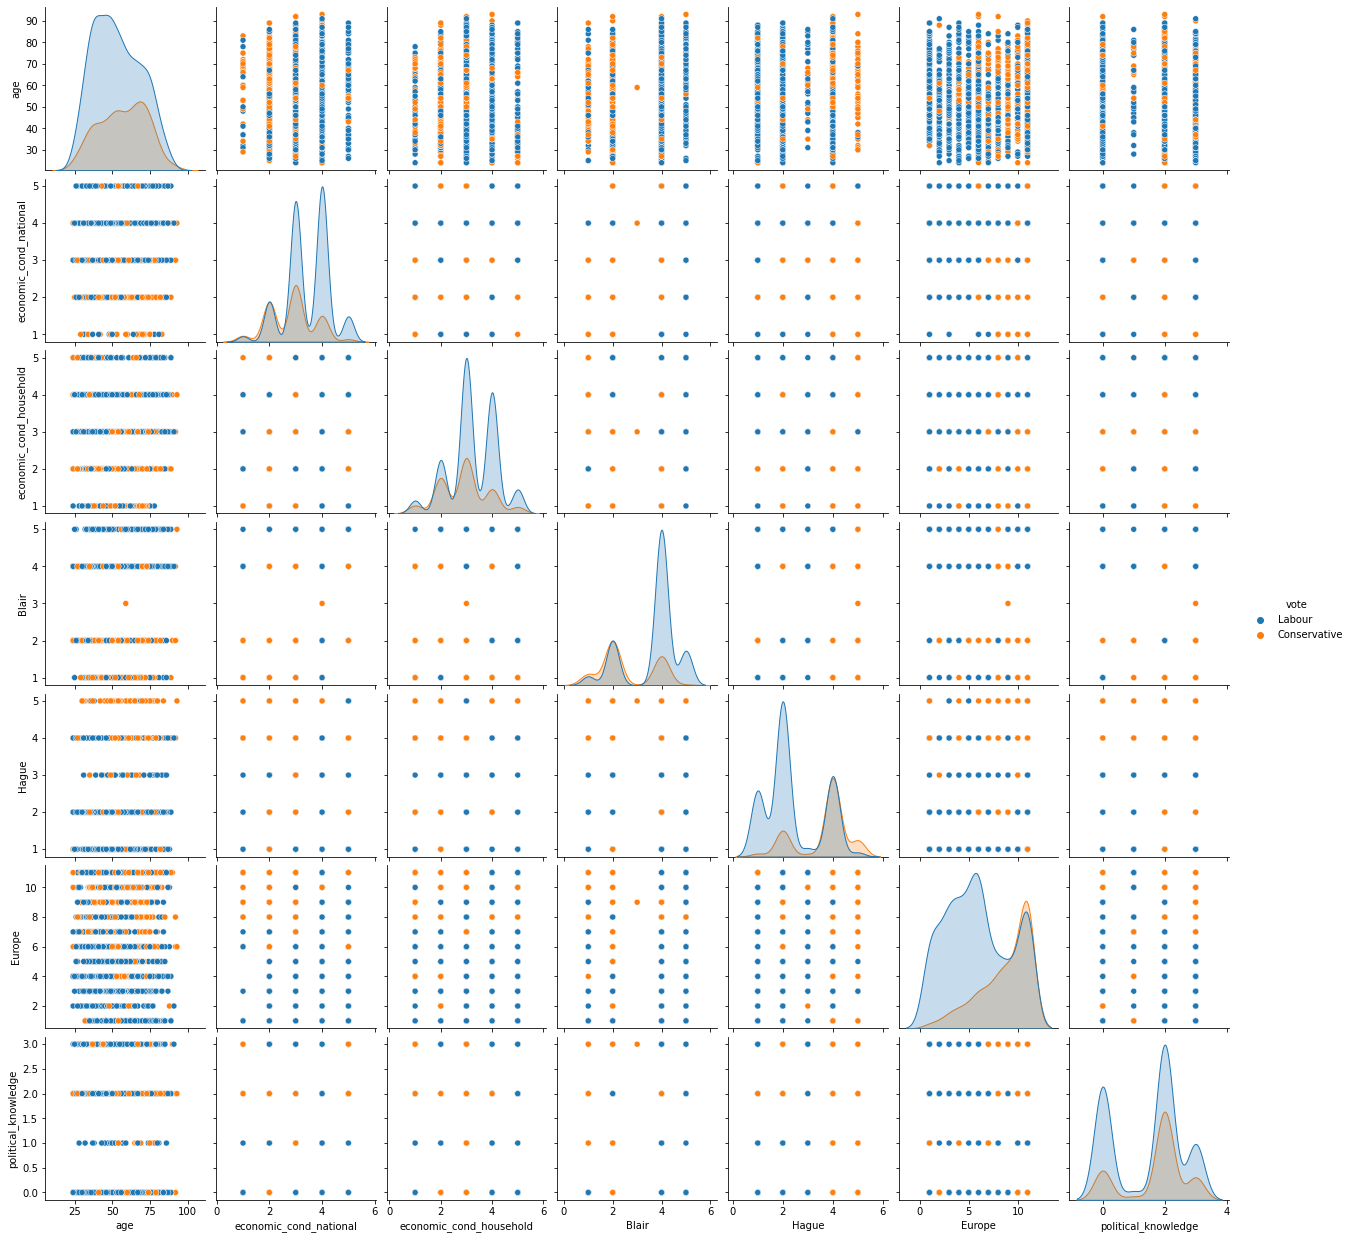

In [428]:
sns.pairplot(data=election,hue='vote')

<AxesSubplot:>

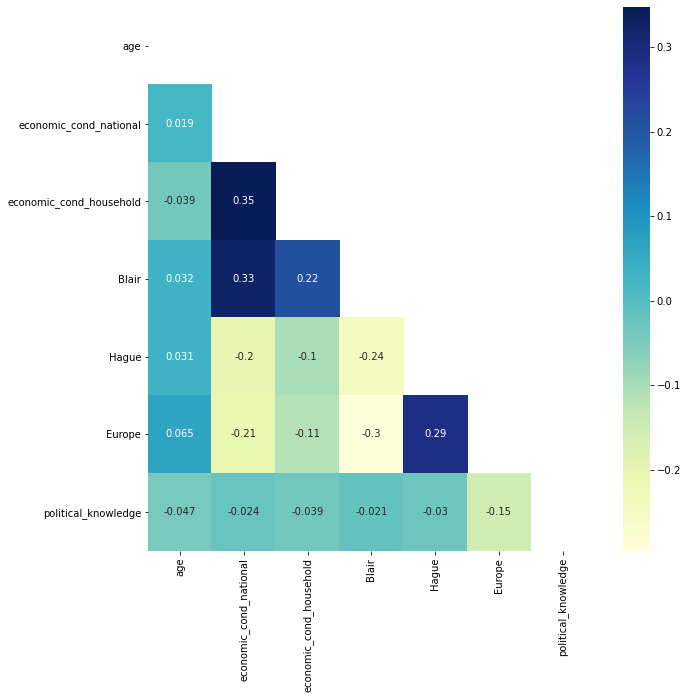

In [429]:
cor=election.corr()
plt.figure(figsize=(10,10))
sns.heatmap(data=cor,mask=np.triu(cor),annot=True,cmap='YlGnBu')

## Chi square test to check dependency

H0: No relationship exists

Ha: Relationship exists

In [430]:
temp=list(cols)
temp.remove('age')
for col in temp:
    chi,p,dof,exp=chi2_contingency(pd.crosstab(election.vote,election[col]))
    print('\n',col,'\n P value=',p,' \t','Rejecting the null' if p<0.05 else 'Accepting the null')


 economic_cond_national 
 P value= 1.1786763801098676e-30  	 Rejecting the null

 economic_cond_household 
 P value= 8.700302589287633e-12  	 Rejecting the null

 Blair 
 P value= 5.306407775278673e-60  	 Rejecting the null

 Hague 
 P value= 6.93225299056832e-73  	 Rejecting the null

 Europe 
 P value= 5.65172698427529e-47  	 Rejecting the null

 political_knowledge 
 P value= 1.962517003320564e-07  	 Rejecting the null


In [431]:
election['gender']=pd.Categorical(election.gender).codes

In [432]:
election.head()

vote  age  economic_cond_national  economic_cond_household  Blair  Hague  Europe  political_knowledge  gender
1  Labour   43                       3                        3      4      1       2                    2       0
2  Labour   36                       4                        4      4      4       5                    2       1
3  Labour   35                       4                        4      5      2       3                    2       1
4  Labour   24                       4                        2      2      1       4                    0       0
5  Labour   41                       2                        2      1      1       6                    2       1

## Data spliting

In [433]:
y=election.vote
X=election.drop(columns='vote')

In [434]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.30,random_state=1,stratify=y)

In [469]:
def print_metric_score(model,X,y,label,title):
    
    pred=model.predict(X)
    prob=model.predict_proba(X)[:,1]
    #test_pred=model.predict(X_test)
    
    print ('Accuracy score :',accuracy_score(y_true=y,y_pred=pred))
    print(classification_report(y_true=y,y_pred=pred))
    #print(metrics.confusion_matrix(y_true=y,y_pred=pred))
    plot_confusion_matrix(model,X,y)
    plt.title('Confusion Matrix of '+label)
    
    fpr, tpr, thresholds=roc_curve(y,prob,pos_label='Labour')
    plt.figure()
    plt.plot([0,1],[0,1],linestyle='--')
    plt.plot(fpr,tpr)
    plt.title('Roc Curve of '+title+' for '+label)
    print('\n\n')
    print('Area Under the curve :',roc_auc_score(y,prob))

## Model creation

### Logistic Regressor (base model)

In [471]:
log_clf=LogisticRegression(solver='newton-cg')
log_clf.fit(X_train,y_train)


LogisticRegression(solver='newton-cg')

### Train metrics

Accuracy score : 0.8284637134778511
              precision    recall  f1-score   support

Conservative       0.74      0.66      0.70       322
      Labour       0.86      0.90      0.88       739

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.82      0.83      0.83      1061




Area Under the curve : 0.8770371241983879


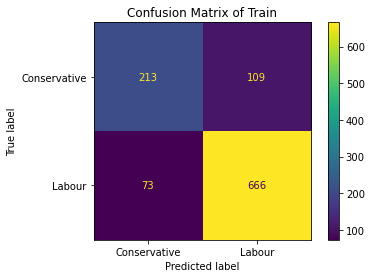

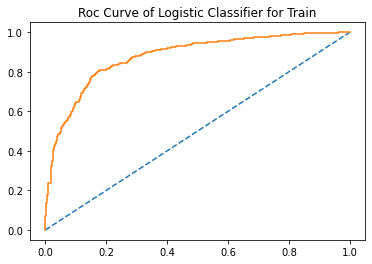

In [472]:
print_metric_score(log_clf,X_train,y_train,'Train','Logistic Classifier')

### Test Metric

Accuracy score : 0.8552631578947368
              precision    recall  f1-score   support

Conservative       0.81      0.68      0.74       138
      Labour       0.87      0.93      0.90       318

    accuracy                           0.86       456
   macro avg       0.84      0.81      0.82       456
weighted avg       0.85      0.86      0.85       456




Area Under the curve : 0.9128611794731565


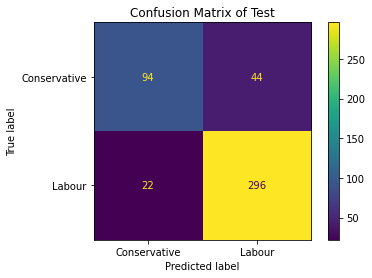

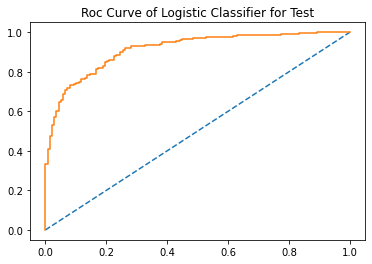

In [473]:
print_metric_score(log_clf,X_test,y_test,'Test','Logistic Classifier')

### LDA (base)

In [474]:
lda_clf=LinearDiscriminantAnalysis()
lda_clf.fit(X_train,y_train)

LinearDiscriminantAnalysis()

### Train metric

Accuracy score : 0.822808671065033
              precision    recall  f1-score   support

Conservative       0.72      0.67      0.70       322
      Labour       0.86      0.89      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.78      0.79      1061
weighted avg       0.82      0.82      0.82      1061




Area Under the curve : 0.876932063641483


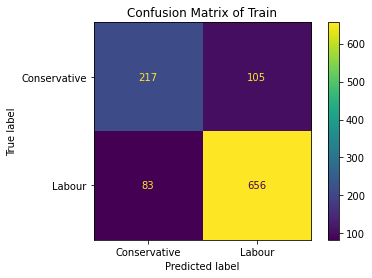

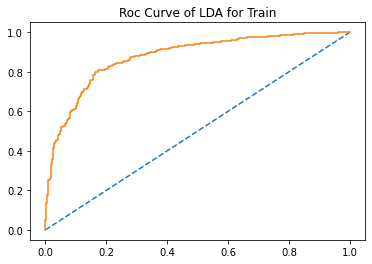

In [475]:
print_metric_score(lda_clf,X_train,y_train,'Train','LDA')

### Test metric

Accuracy score : 0.8530701754385965
              precision    recall  f1-score   support

Conservative       0.80      0.69      0.74       138
      Labour       0.87      0.92      0.90       318

    accuracy                           0.85       456
   macro avg       0.84      0.81      0.82       456
weighted avg       0.85      0.85      0.85       456




Area Under the curve : 0.9143651444717892


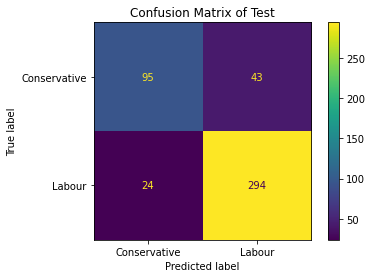

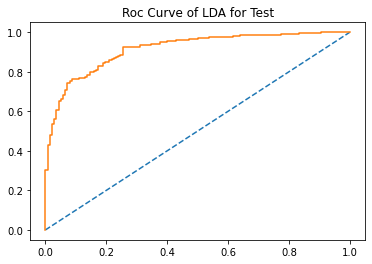

In [476]:
print_metric_score(lda_clf,X_test,y_test,'Test','LDA')

### Naive Bayer Classifier (base)

In [477]:
NB_clf=GaussianNB()
NB_clf.fit(X_train,y_train)

GaussianNB()

Accuracy score : 0.8199811498586239
              precision    recall  f1-score   support

Conservative       0.70      0.70      0.70       322
      Labour       0.87      0.87      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.79      0.79      1061
weighted avg       0.82      0.82      0.82      1061




Area Under the curve : 0.8731624908597315


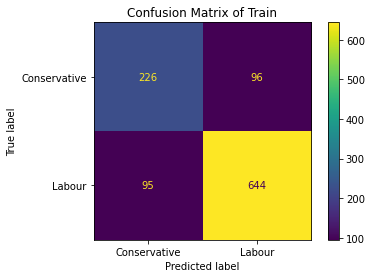

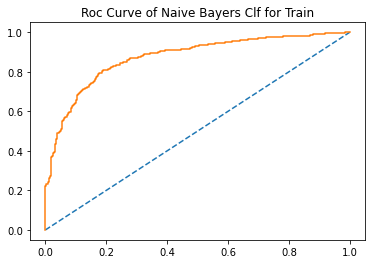

In [478]:
print_metric_score(NB_clf,X_train,y_train,'Train','Naive Bayers Clf')

Accuracy score : 0.8574561403508771
              precision    recall  f1-score   support

Conservative       0.79      0.72      0.75       138
      Labour       0.88      0.92      0.90       318

    accuracy                           0.86       456
   macro avg       0.84      0.82      0.83       456
weighted avg       0.86      0.86      0.86       456




Area Under the curve : 0.9124965818977304


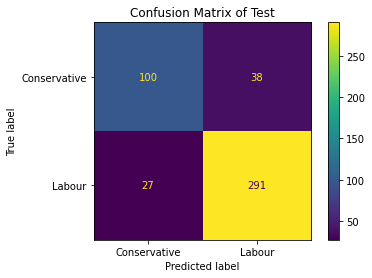

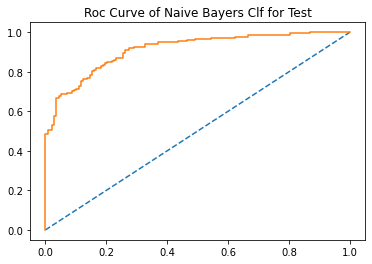

In [479]:
print_metric_score(NB_clf,X_test,y_test,'Test','Naive Bayers Clf')

### KNN

In [480]:
scaled_df=election.copy()
scaled_df[cols]=scaled_df[cols].apply(zscore,axis=0)
scaled_df.head()

vote       age  economic_cond_national  economic_cond_household  ...     Hague    Europe  political_knowledge  gender
1  Labour -0.716161               -0.278185                -0.148020  ... -1.419969 -1.437338             0.423832       0
2  Labour -1.162118                0.856242                 0.926367  ...  1.014951 -0.527684             0.423832       1
3  Labour -1.225827                0.856242                 0.926367  ... -0.608329 -1.134120             0.423832       1
4  Labour -1.926617                0.856242                -1.222408  ... -1.419969 -0.830902            -1.421084       0
5  Labour -0.843577               -1.412613                -1.222408  ... -1.419969 -0.224465             0.423832       1

[5 rows x 9 columns]

In [481]:
X_train_scaled, X_test_scaled, y_train, y_test=train_test_split(scaled_df.drop(columns='vote'),scaled_df['vote'],test_size=0.30,random_state=1,stratify=y)

In [482]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train_scaled,y_train)

KNeighborsClassifier()

Accuracy score : 0.8576814326107446
              precision    recall  f1-score   support

Conservative       0.79      0.73      0.76       322
      Labour       0.89      0.91      0.90       739

    accuracy                           0.86      1061
   macro avg       0.84      0.82      0.83      1061
weighted avg       0.86      0.86      0.86      1061




Area Under the curve : 0.923957168912161


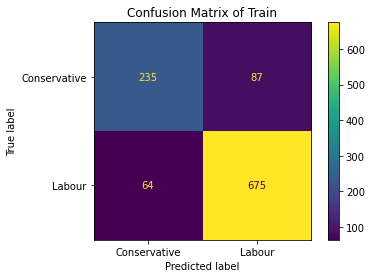

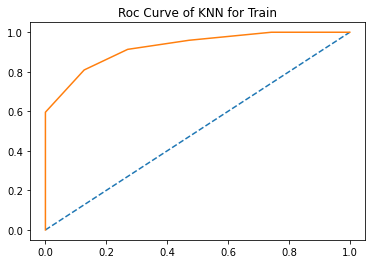

In [483]:
print_metric_score(knn_clf,X_train_scaled,y_train,'Train','KNN')

Accuracy score : 0.8530701754385965
              precision    recall  f1-score   support

Conservative       0.77      0.74      0.75       138
      Labour       0.89      0.90      0.90       318

    accuracy                           0.85       456
   macro avg       0.83      0.82      0.82       456
weighted avg       0.85      0.85      0.85       456




Area Under the curve : 0.8733365235621184


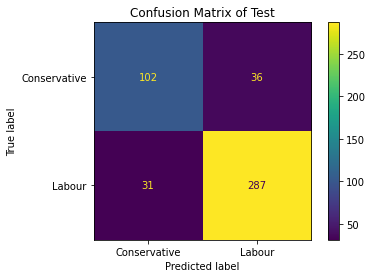

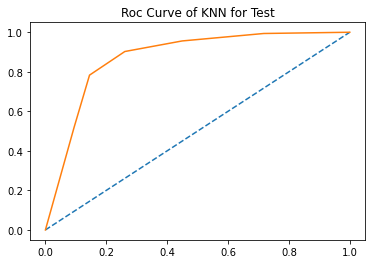

In [484]:
print_metric_score(knn_clf,X_test_scaled,y_test,'Test','KNN')

### Random Forest(base)

In [485]:
rforest=RandomForestClassifier()
rforest.fit(X_train,y_train)

RandomForestClassifier()

Accuracy score : 1.0
              precision    recall  f1-score   support

Conservative       1.00      1.00      1.00       322
      Labour       1.00      1.00      1.00       739

    accuracy                           1.00      1061
   macro avg       1.00      1.00      1.00      1061
weighted avg       1.00      1.00      1.00      1061




Area Under the curve : 1.0


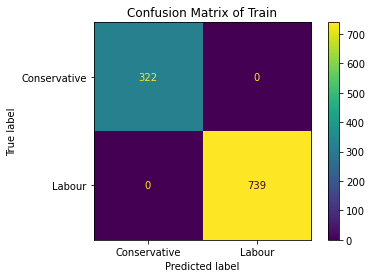

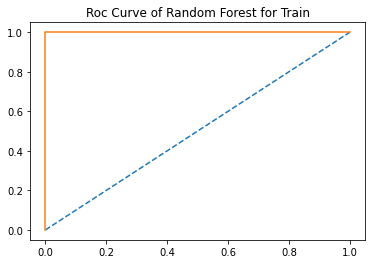

In [486]:
print_metric_score(rforest,X_train,y_train,'Train','Random Forest')

Accuracy score : 0.8421052631578947
              precision    recall  f1-score   support

Conservative       0.77      0.68      0.72       138
      Labour       0.87      0.91      0.89       318

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.84      0.84      0.84       456




Area Under the curve : 0.898869747516179


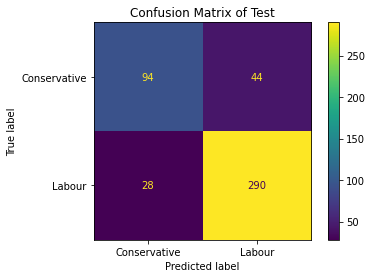

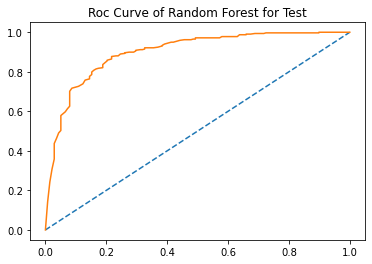

In [487]:
print_metric_score(rforest,X_test,y_test,'Test','Random Forest')

### Ada Boost Classifier

In [488]:
adaboost_clf=AdaBoostClassifier()
adaboost_clf.fit(X_train,y_train)

AdaBoostClassifier()

Accuracy score : 0.8397737983034873
              precision    recall  f1-score   support

Conservative       0.75      0.70      0.73       322
      Labour       0.87      0.90      0.89       739

    accuracy                           0.84      1061
   macro avg       0.81      0.80      0.81      1061
weighted avg       0.84      0.84      0.84      1061




Area Under the curve : 0.9000033619378209


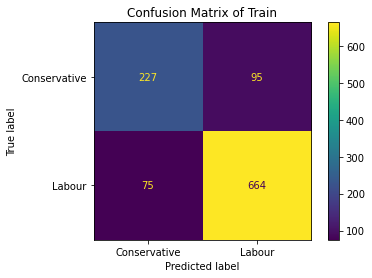

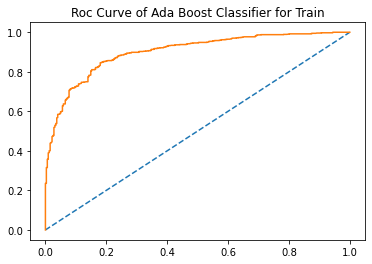

In [489]:
print_metric_score(adaboost_clf,X_train,y_train,'Train','Ada Boost Classifier')

Accuracy score : 0.8355263157894737
              precision    recall  f1-score   support

Conservative       0.76      0.67      0.71       138
      Labour       0.86      0.91      0.88       318

    accuracy                           0.84       456
   macro avg       0.81      0.79      0.80       456
weighted avg       0.83      0.84      0.83       456




Area Under the curve : 0.9104571142101906


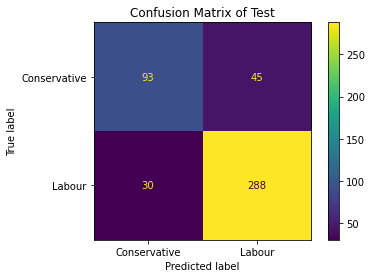

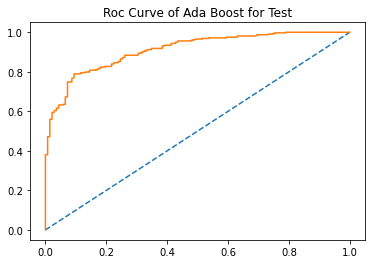

In [490]:
print_metric_score(adaboost_clf,X_test,y_test,'Test','Ada Boost')

### Gradient Boost Classifier

In [491]:
grad_boost=GradientBoostingClassifier()
grad_boost.fit(X_train,y_train)

GradientBoostingClassifier()

Accuracy score : 0.885956644674835
              precision    recall  f1-score   support

Conservative       0.84      0.78      0.81       322
      Labour       0.91      0.93      0.92       739

    accuracy                           0.89      1061
   macro avg       0.87      0.86      0.86      1061
weighted avg       0.88      0.89      0.88      1061




Area Under the curve : 0.9470137587305323


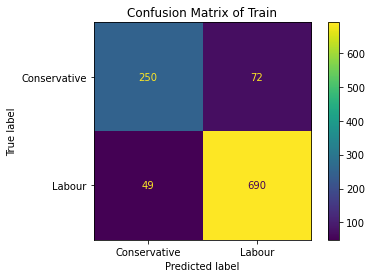

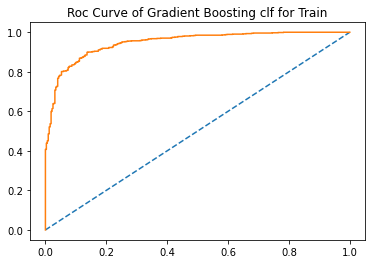

In [492]:
print_metric_score(grad_boost,X_train,y_train,'Train','Gradient Boosting clf')

Accuracy score : 0.8399122807017544
              precision    recall  f1-score   support

Conservative       0.76      0.68      0.72       138
      Labour       0.87      0.91      0.89       318

    accuracy                           0.84       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.84      0.84      0.84       456




Area Under the curve : 0.9042475617537145


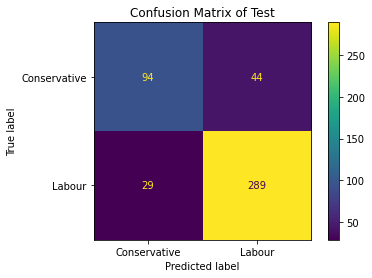

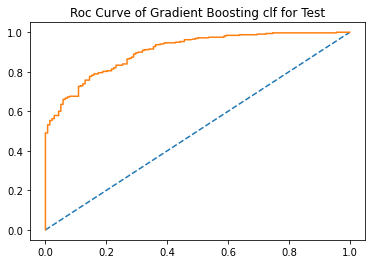

In [493]:
print_metric_score(grad_boost,X_test,y_test,'Test','Gradient Boosting clf')

In [494]:
def get_metric_score(model,Xtrain,Xtest,y_train,y_test):
    
    train_pred=model.predict(Xtrain)
    test_pred=model.predict(Xtest)
    
    train_accuracy=accuracy_score(y_true=y_train,y_pred=train_pred)
    test_accuracy=accuracy_score(y_true=y_test,y_pred=test_pred)
    
    train_precision=precision_score(y_train,train_pred,pos_label='Conservative')
    test_precision=precision_score(y_test,test_pred,pos_label='Conservative')
    
    train_recall=recall_score(y_train,train_pred,pos_label='Conservative')
    test_recall=recall_score(y_test,test_pred,pos_label='Conservative')
    
    train_auc=roc_auc_score(y_train,model.predict_proba(Xtrain)[:,1])
    test_auc=roc_auc_score(y_test,model.predict_proba(Xtest)[:,1])
    
    return list((train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_auc,test_auc))
    
    

In [495]:
models=[log_clf,lda_clf,NB_clf,knn_clf,rforest,adaboost_clf,grad_boost]



acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
auc_train=[]
auc_test=[]

for x in models:
    
    if(x==knn_clf):
        j=get_metric_score(x,X_train_scaled,X_test_scaled,y_train,y_test)
    else:
        j=get_metric_score(x,X_train,X_test,y_train,y_test)
    
    acc_train.append(np.round(j[0],3))
    acc_test.append(np.round(j[1],3))
    precision_train.append(np.round(j[2],3))
    precision_test.append(np.round(j[3],3))
    recall_train.append(np.round(j[4],3))
    recall_test.append(np.round(j[5],3))
    auc_train.append(np.round(j[6],3))
    auc_test.append(np.round(j[7],3))
    
    
    
    

base_frame = pd.DataFrame({'Model':['log_clf','lda_clf','NB_clf','knn_clf','rforest','adaboost_clf','grad_boost'],
                                 'Train_Accuracy': acc_train,
                                 'Test_Accuracy': acc_test,
                                 'Train_Recall':recall_train,
                                 'Test_Recall':recall_test,
                                 'Train_Precision':precision_train,
                                 'Test_Precision':precision_test,
                                'Train_AUC':auc_train,
                                'Test_AUC':auc_test}) 
base_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  ...  Train_Precision  Test_Precision  Train_AUC  Test_AUC
0       log_clf           0.828          0.855         0.661  ...            0.745           0.810      0.877     0.913
1       lda_clf           0.823          0.853         0.674  ...            0.723           0.798      0.877     0.914
2        NB_clf           0.820          0.857         0.702  ...            0.704           0.787      0.873     0.912
3       knn_clf           0.858          0.853         0.730  ...            0.786           0.767      0.924     0.873
4       rforest           1.000          0.842         1.000  ...            1.000           0.770      1.000     0.899
5  adaboost_clf           0.840          0.836         0.705  ...            0.752           0.756      0.900     0.910
6    grad_boost           0.886          0.840         0.776  ...            0.836           0.764      0.947     0.904

[7 rows x 9 columns]

### Applying Smote

Accuracy score : 0.8289473684210527
              precision    recall  f1-score   support

Conservative       0.68      0.82      0.74       138
      Labour       0.91      0.83      0.87       318

    accuracy                           0.83       456
   macro avg       0.80      0.83      0.81       456
weighted avg       0.84      0.83      0.83       456




Area Under the curve : 0.9173730744690549
Accuracy score : 0.8333333333333334
              precision    recall  f1-score   support

Conservative       0.69      0.82      0.75       138
      Labour       0.91      0.84      0.88       318

    accuracy                           0.83       456
   macro avg       0.80      0.83      0.81       456
weighted avg       0.85      0.83      0.84       456




Area Under the curve : 0.9169173274997721
Accuracy score : 0.8223684210526315
              precision    recall  f1-score   support

Conservative       0.67      0.80      0.73       138
      Labour       0.90      0.83      

Model  Train_Accuracy  Test_Accuracy  Train_Recall  ...  Train_Precision  Test_Precision  Train_AUC  Test_AUC
0       log_clf           0.818          0.829         0.823  ...            0.815           0.681      0.884     0.917
1       lda_clf           0.816          0.833         0.825  ...            0.810           0.689      0.883     0.917
2        NB_clf           0.811          0.822         0.798  ...            0.818           0.675      0.885     0.911
3       knn_clf           0.874          0.785         0.917  ...            0.844           0.601      0.955     0.876
4       rforest           0.999          0.842         1.000  ...            0.999           0.723      1.000     0.892
5  adaboost_clf           0.837          0.840         0.850  ...            0.828           0.699      0.913     0.908
6    grad_boost           0.884          0.818         0.897  ...            0.874           0.675      0.951     0.901

[7 rows x 9 columns]

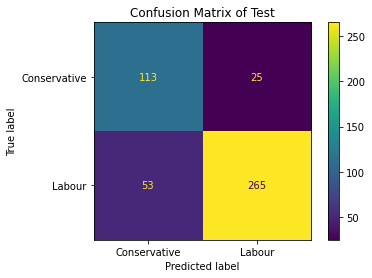

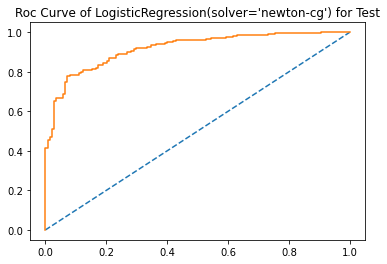

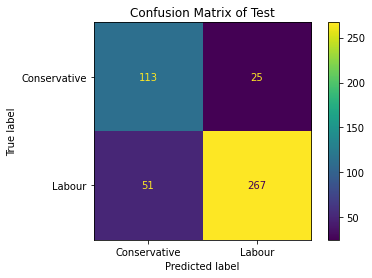

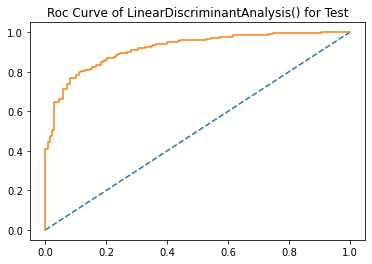

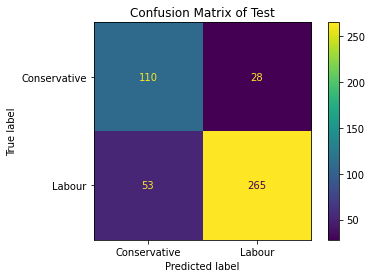

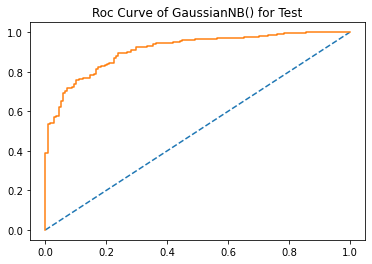

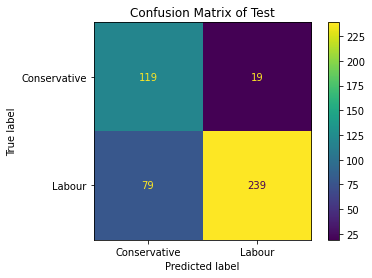

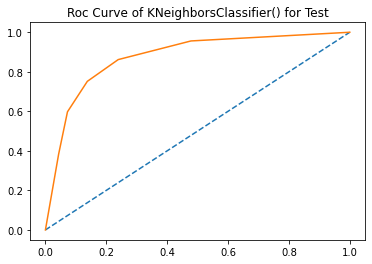

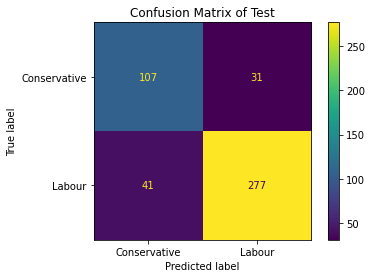

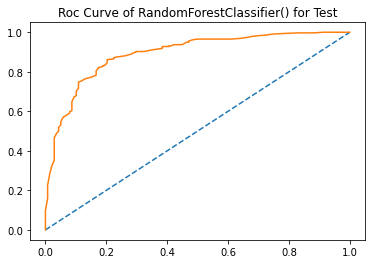

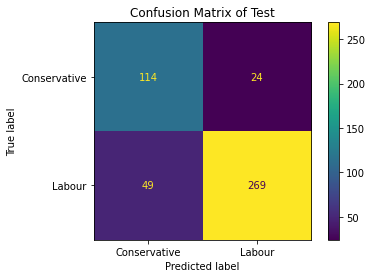

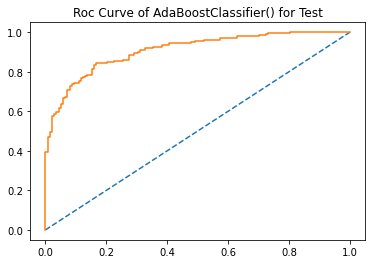

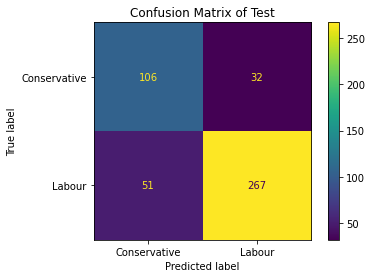

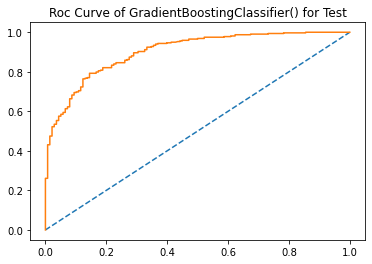

In [500]:
smote=SMOTE(random_state=2)

X_train_bal,y_train_bal=smote.fit_resample(X_train,y_train.ravel())


acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
auc_train=[]
auc_test=[]

for x in models:
    

    
    
    if(x==knn_clf):
        temp=X_train_bal.copy()
        temp[cols]=temp[cols].apply(zscore,axis=0)
        x.fit(temp,y_train_bal)
        j=get_metric_score(x,temp,X_test_scaled,y_train_bal,y_test)
        #print_metric_score(x,X_test_scaled,y_test,'Test',str(x))
    else:
        x.fit(X_train_bal,y_train_bal)
        j=get_metric_score(x,X_train_bal,X_test,y_train_bal,y_test)
        #print_metric_score(x,X_test,y_test,'Test',str(x))
    
    acc_train.append(np.round(j[0],3))
    acc_test.append(np.round(j[1],3))
    precision_train.append(np.round(j[2],3))
    precision_test.append(np.round(j[3],3))
    recall_train.append(np.round(j[4],3))
    recall_test.append(np.round(j[5],3))
    auc_train.append(np.round(j[6],3))
    auc_test.append(np.round(j[7],3))
    
    
    
    

smote_frame = pd.DataFrame({'Model':['log_clf','lda_clf','NB_clf','knn_clf','rforest','adaboost_clf','grad_boost'],
                                 'Train_Accuracy': acc_train,
                                 'Test_Accuracy': acc_test,
                                 'Train_Recall':recall_train,
                                 'Test_Recall':recall_test,
                                 'Train_Precision':precision_train,
                                 'Test_Precision':precision_test,
                                'Train_AUC':auc_train,
                                'Test_AUC':auc_test}) 
smote_frame



In [497]:
base_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  ...  Train_Precision  Test_Precision  Train_AUC  Test_AUC
0       log_clf           0.828          0.855         0.661  ...            0.745           0.810      0.877     0.913
1       lda_clf           0.823          0.853         0.674  ...            0.723           0.798      0.877     0.914
2        NB_clf           0.820          0.857         0.702  ...            0.704           0.787      0.873     0.912
3       knn_clf           0.858          0.853         0.730  ...            0.786           0.767      0.924     0.873
4       rforest           1.000          0.842         1.000  ...            1.000           0.770      1.000     0.899
5  adaboost_clf           0.840          0.836         0.705  ...            0.752           0.756      0.900     0.910
6    grad_boost           0.886          0.840         0.776  ...            0.836           0.764      0.947     0.904

[7 rows x 9 columns]

In [501]:
smote_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  ...  Train_Precision  Test_Precision  Train_AUC  Test_AUC
0       log_clf           0.818          0.829         0.823  ...            0.815           0.681      0.884     0.917
1       lda_clf           0.816          0.833         0.825  ...            0.810           0.689      0.883     0.917
2        NB_clf           0.811          0.822         0.798  ...            0.818           0.675      0.885     0.911
3       knn_clf           0.874          0.785         0.917  ...            0.844           0.601      0.955     0.876
4       rforest           0.999          0.842         1.000  ...            0.999           0.723      1.000     0.892
5  adaboost_clf           0.837          0.840         0.850  ...            0.828           0.699      0.913     0.908
6    grad_boost           0.884          0.818         0.897  ...            0.874           0.675      0.951     0.901

[7 rows x 9 columns]

### GRID SEARCH

In [502]:
scorer=metrics.make_scorer(precision_score)

### Logistic classifier(tuned)

In [509]:
grid_param={'penalty':['l2','none'],
           'fit_intercept':[True,False],
           'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
           'class_weight':['balanced'],
           'tol':[0.01,0.001,0.0001,0.00001]}


grid_search=GridSearchCV(estimator=LogisticRegression(max_iter=1000,n_jobs=2),param_grid=grid_param,cv=5,scoring=scorer)

In [510]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, n_jobs=2),
             param_grid={'class_weight': ['balanced'],
                         'fit_intercept': [True, False],
                         'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga'],
                         'tol': [0.01, 0.001, 0.0001, 1e-05]},
             scoring=make_scorer(precision_score))

In [512]:
log_clf_tuned=grid_search.best_estimator_

In [645]:
log_clf_tuned.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=2,
                   solver='newton-cg', tol=0.01)>

Accuracy score : 0.8133836003770029
              precision    recall  f1-score   support

Conservative       0.65      0.82      0.73       322
      Labour       0.91      0.81      0.86       739

    accuracy                           0.81      1061
   macro avg       0.78      0.82      0.79      1061
weighted avg       0.83      0.81      0.82      1061




Area Under the curve : 0.8775540221383606


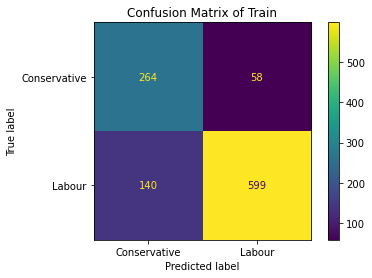

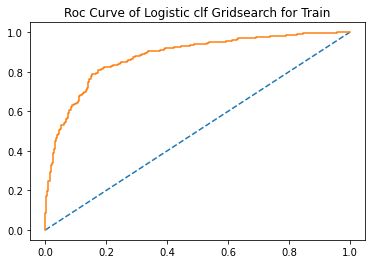

In [630]:
print_metric_score(log_clf_tuned,X_train,y_train,'Train','Logistic clf Gridsearch')

Accuracy score : 0.8289473684210527
              precision    recall  f1-score   support

Conservative       0.68      0.81      0.74       138
      Labour       0.91      0.84      0.87       318

    accuracy                           0.83       456
   macro avg       0.80      0.82      0.81       456
weighted avg       0.84      0.83      0.83       456




Area Under the curve : 0.9141372709871479


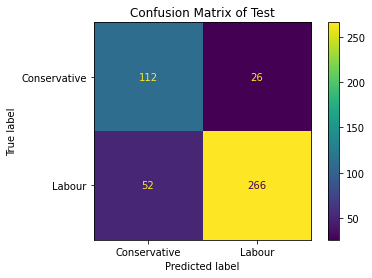

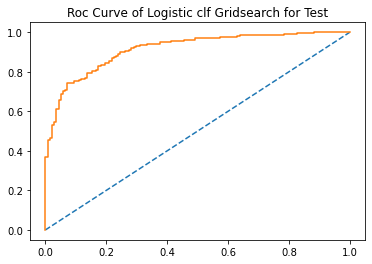

In [631]:
print_metric_score(log_clf_tuned,X_test,y_test,'Test','Logistic clf Gridsearch')

### LDA(tuned)

In [542]:
grid_param={'solver':['svd','lsqr','eigen'],
           'store_covariance':[True,False],
           'tol':[0.01,0.001,0.0001,0.00001]}
          

grid_search=GridSearchCV(estimator=LinearDiscriminantAnalysis(),param_grid=grid_param,cv=5,scoring=scorer)
grid_search.fit(X_train,y_train)

In [548]:
lda_clf_tuned=grid_search.best_estimator_

In [648]:
lda_clf_tuned.get_params

<bound method BaseEstimator.get_params of LinearDiscriminantAnalysis(store_covariance=True, tol=0.01)>

In [649]:
lda_clf_tuned.solver

'svd'

Accuracy score : 0.822808671065033
              precision    recall  f1-score   support

Conservative       0.72      0.67      0.70       322
      Labour       0.86      0.89      0.87       739

    accuracy                           0.82      1061
   macro avg       0.79      0.78      0.79      1061
weighted avg       0.82      0.82      0.82      1061




Area Under the curve : 0.876932063641483


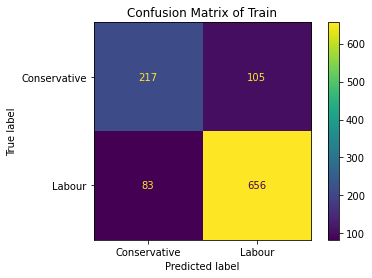

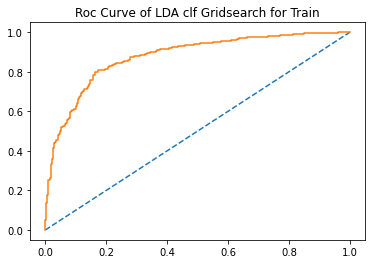

In [632]:
print_metric_score(lda_clf_tuned,X_train,y_train,'Train','LDA clf Gridsearch')

Accuracy score : 0.8530701754385965
              precision    recall  f1-score   support

Conservative       0.80      0.69      0.74       138
      Labour       0.87      0.92      0.90       318

    accuracy                           0.85       456
   macro avg       0.84      0.81      0.82       456
weighted avg       0.85      0.85      0.85       456




Area Under the curve : 0.9143651444717892


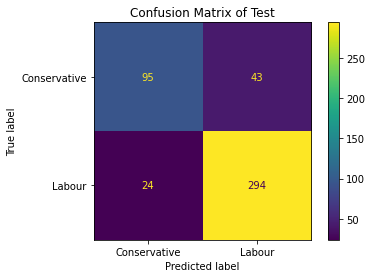

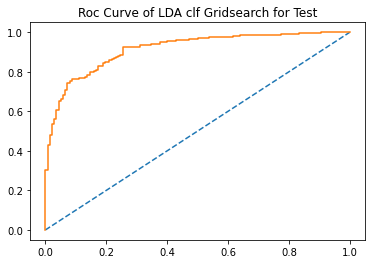

In [633]:
print_metric_score(lda_clf_tuned,X_test,y_test,'Test','LDA clf Gridsearch')

### Naive Bayers (Tuned)

In [577]:
grid_param={'var_smoothing':np.arange(0.01,0.1,0.001)}

grid_search=GridSearchCV(estimator=GaussianNB(),param_grid=grid_param,cv=5,scoring=scorer)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
       0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
       0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
       0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
       0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
       0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
       0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
       0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
       0.1  ])},
             scoring=make_scorer(precision_score))

In [578]:
NB_clf_tuned=grid_search.best_estimator_

In [650]:
NB_clf_tuned.get_params

<bound method BaseEstimator.get_params of GaussianNB(var_smoothing=0.01)>

Accuracy score : 0.8067860508953817
              precision    recall  f1-score   support

Conservative       0.74      0.56      0.64       322
      Labour       0.83      0.91      0.87       739

    accuracy                           0.81      1061
   macro avg       0.78      0.74      0.75      1061
weighted avg       0.80      0.81      0.80      1061




Area Under the curve : 0.8538943847233545


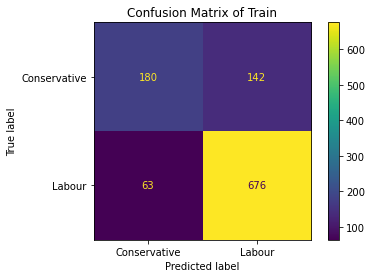

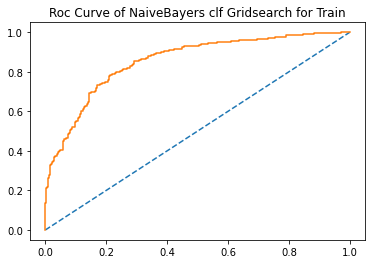

In [634]:
print_metric_score(NB_clf_tuned,X_train,y_train,'Train','NaiveBayers clf Gridsearch')

Accuracy score : 0.8508771929824561
              precision    recall  f1-score   support

Conservative       0.82      0.65      0.73       138
      Labour       0.86      0.94      0.90       318

    accuracy                           0.85       456
   macro avg       0.84      0.79      0.81       456
weighted avg       0.85      0.85      0.85       456




Area Under the curve : 0.8953377085042384


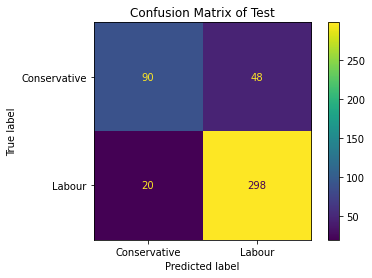

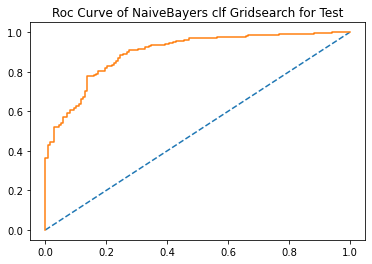

In [635]:
print_metric_score(NB_clf_tuned,X_test,y_test,'Test','NaiveBayers clf Gridsearch')

### KNN(tuned)

In [604]:
grid_param={'n_neighbors':np.arange(3,50,2),
           'weights':['uniform','distance'],
           'algorithm':['auto','ball_tree','kd_tree','brute'],
           'leaf_size':np.arange(5,50,5),
           'p':[1,2]}
grid_search=GridSearchCV(estimator=KNeighborsClassifier(),param_grid=grid_param,cv=5,scoring=scorer,verbose=2)
grid_search.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=3, p=1, weights=distance; total ti

[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neigh

[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neigh

[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neigh

[CV] END algorithm=auto, leaf_size=5, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=5, n_neigh

[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neig

[CV] END algorithm=auto, leaf_size=10, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=10, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neig

[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=15, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neig

[CV] END algorithm=auto, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neig

[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=25, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=25, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neig

[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_

[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=35, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=40, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neig

[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=40, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=40, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, 

[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=45, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=

[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=17, p=2, weights=uniform; total time=   

[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=27, p=1, weights=uniform; total time=   

[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=35, p=2, weights=uniform; total time=   

[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=5, n_neighbors=43, p=2, weights=distance; total time=   

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=5, p=1, weights=uniform; total time=   

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=13, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=21, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=29, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=37, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=10, n_neighbors=47, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=15, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=23, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=33, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=41, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=27, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=35, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=20, n_neighbors=43, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=5, p=1, weights=uniform; total time=   

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=13, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=21, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=29, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=37, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=25, n_neighbors=47, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=7, p=1, weights=distance; total time=   

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=15, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=23, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=33, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=41, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=30, n_neighbors=49, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=11, p=1, weights=uniform; total time=

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=19, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=27, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=37, p=1, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=35, n_neighbors=45, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=5, p=1, weights=distance; total time=   

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=13, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=23, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=31, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=39, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=40, n_neighbors=49, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=9, p=2, weights=distance; total time=   

[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=17, p=2, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=27, p=1, weights=distance; tota

[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=35, p=2, weights=uniform; tota

[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, leaf_size=45, n_neighbors=43, p=2, weights=distance; tota

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tre

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=10, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=5, p=1, weights=distance; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=15, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END al

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=5, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=25, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END al

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=30, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=31, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=35, n_neighbors=49, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=40, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algori

[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, leaf_size=45, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] 

[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neig

[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=13, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=31, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=5, n_neighbors=49, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=9, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=11, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_s

[CV] END algorithm=brute, leaf_size=10, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=19, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=27, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=10, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=23, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=15, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=29, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=45, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=20, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=15, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=33, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=25, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=41, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=25, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=11, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=30, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=19, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=21, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=30, n_neighbors=37, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=30, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=25, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=27, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=35, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=3, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=13, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=21, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=23, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=40, n_neighbors=29, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=31, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=39, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=47, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=40, n_neighbors=49, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=45, n_neighbors=7, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=9, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size

[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=17, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=19, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=1, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=27, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=35, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute,

[CV] END algorithm=brute, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=43, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute, leaf_size=45, n_neighbors=45, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=brute,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                         'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49]),
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring=make_scorer(precision_score), verbose=2)

In [605]:
knn_clf_tuned=grid_search.best_estimator_

In [651]:
knn_clf_tuned.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(leaf_size=5, n_neighbors=3, p=1)>

Accuracy score : 0.879359095193214
              precision    recall  f1-score   support

Conservative       0.81      0.80      0.80       322
      Labour       0.91      0.92      0.91       739

    accuracy                           0.88      1061
   macro avg       0.86      0.86      0.86      1061
weighted avg       0.88      0.88      0.88      1061




Area Under the curve : 0.9473142319232806


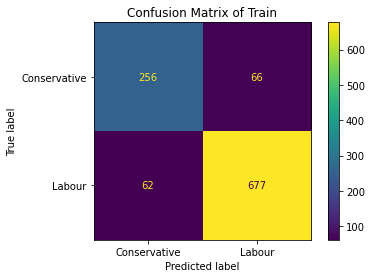

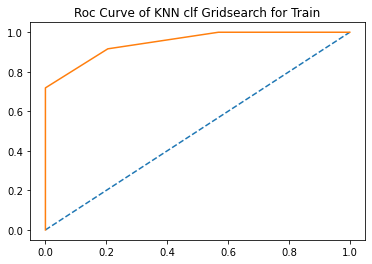

In [636]:
print_metric_score(knn_clf_tuned,X_train_scaled,y_train,'Train','KNN clf Gridsearch')

Accuracy score : 0.5855263157894737
              precision    recall  f1-score   support

Conservative       0.34      0.38      0.36       138
      Labour       0.72      0.67      0.69       318

    accuracy                           0.59       456
   macro avg       0.53      0.53      0.53       456
weighted avg       0.60      0.59      0.59       456




Area Under the curve : 0.5563189317291041


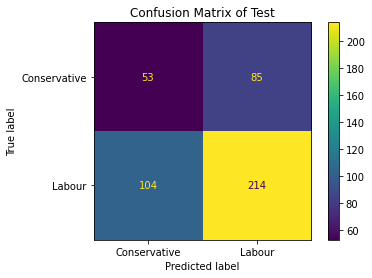

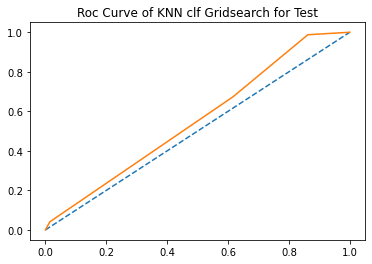

In [637]:
print_metric_score(knn_clf_tuned,X_test,y_test,'Test','KNN clf Gridsearch')

### Random Forest (tuned)

In [611]:
grid_param={'n_estimators':[100,300,500],
            'max_features':[3,4,5],
           'max_depth':[3,5,7],
           'min_samples_split':[30,50,70,100],
            'min_samples_leaf':[5,10,15],
            }

grid_search=GridSearchCV(estimator=RandomForestClassifier(),param_grid=grid_param,cv=5,scoring=scorer,verbose=2)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.7s
[CV] END max_depth=3, max_features=3, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.5s


[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   1.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   1.0s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.2s
[CV] END max_depth=3, max_features=3, min_samples_leaf=1

[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=3, min_samples_leaf=1

[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.6s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=4, min_samples_leaf=5, min_sa

[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=4, min_samples_lea

[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.4s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.8s
[CV] END max_depth=3, max_features=4, min_sample

[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=3, max_features=5, min_samples_leaf=1

[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=3, max_features=5, min_samples_leaf=1

[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=5, min_sa

[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=3, min_samples_leaf=1

[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_leaf=15, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=3, min_samples_le

[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=4, min_samples_leaf=5

[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   1.3s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=5, min_sa

[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_features=5, min_samples_leaf=1

[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_features=5, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=5, min_samples_leaf=1

[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.8s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=3, min_samples_leaf=5, min

[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=3, min_sample

[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=5, min_sa

[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=10, min_samples_split=50, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=4, min_samples_leaf=1

[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=4, min_samples_leaf=1

[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.2s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.6s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=5, min_sa

[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   1.0s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   1.0s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=100; total time=   0.1s
[CV] END max_depth=7, max_features=5, min_samples_lea

[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300; total time=   0.5s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=7, max_features=5, min_sample

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [30, 50, 70, 100],
                         'n_estimators': [100, 300, 500]},
             scoring=make_scorer(precision_score), verbose=2)

In [612]:
rforest_clf_tuned=grid_search.best_estimator_

In [652]:
rforest_clf_tuned.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=3, max_features=3, min_samples_leaf=5,
                       min_samples_split=30)>

Accuracy score : 0.825636192271442
              precision    recall  f1-score   support

Conservative       0.78      0.59      0.67       322
      Labour       0.84      0.93      0.88       739

    accuracy                           0.83      1061
   macro avg       0.81      0.76      0.78      1061
weighted avg       0.82      0.83      0.82      1061




Area Under the curve : 0.887837349448222


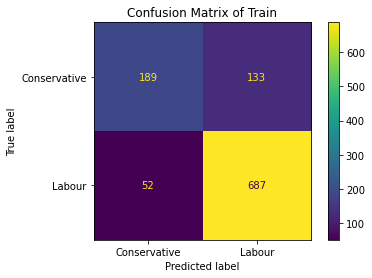

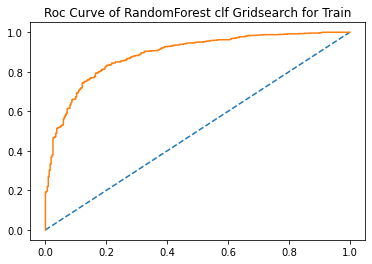

In [638]:
print_metric_score(rforest_clf_tuned,X_train,y_train,'Train','RandomForest clf Gridsearch')

Accuracy score : 0.8421052631578947
              precision    recall  f1-score   support

Conservative       0.83      0.60      0.70       138
      Labour       0.85      0.95      0.89       318

    accuracy                           0.84       456
   macro avg       0.84      0.77      0.80       456
weighted avg       0.84      0.84      0.83       456




Area Under the curve : 0.9100013672409079


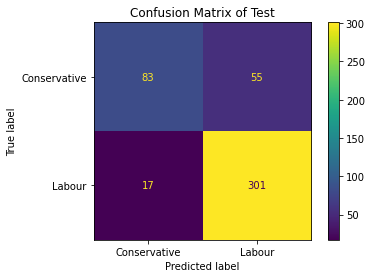

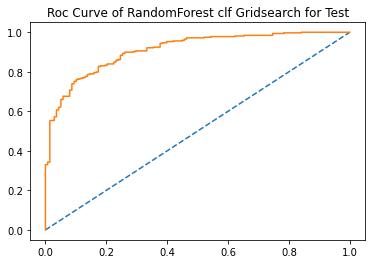

In [639]:
print_metric_score(rforest_clf_tuned,X_test,y_test,'Test','RandomForest clf Gridsearch')

### Ada boost(tuned)

In [613]:
[RandomForestClassifier(max_depth=x) for x in np.arange(1,7,1)]

[RandomForestClassifier(max_depth=1),
 RandomForestClassifier(max_depth=2),
 RandomForestClassifier(max_depth=3),
 RandomForestClassifier(max_depth=4),
 RandomForestClassifier(max_depth=5),
 RandomForestClassifier(max_depth=6)]

In [617]:
grid_param={"base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3)],
    "n_estimators": [100,300,500,1000],
    "learning_rate":[0.0001,0.01,0.1,1],
     "algorithm":['SAMME','SAMME.R']      }

grid_search=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=grid_param,cv=5,scoring=scorer)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                            DecisionTreeClassifier(max_depth=2),
                                            DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.0001, 0.01, 0.1, 1],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring=make_scorer(precision_score))

In [618]:
adaboost_clf_tuned=grid_search.best_estimator_

In [653]:
adaboost_clf_tuned.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.0001, n_estimators=100)>

Accuracy score : 0.7342130065975495
              precision    recall  f1-score   support

Conservative       0.54      0.76      0.63       322
      Labour       0.87      0.72      0.79       739

    accuracy                           0.73      1061
   macro avg       0.71      0.74      0.71      1061
weighted avg       0.77      0.73      0.74      1061




Area Under the curve : 0.7417338353827146


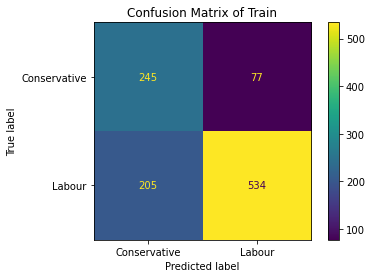

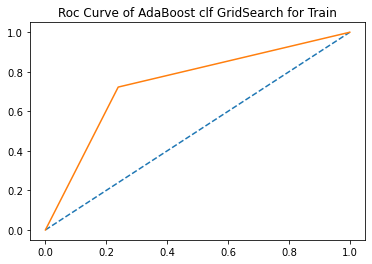

In [640]:
print_metric_score(adaboost_clf_tuned,X_train,y_train,'Train','AdaBoost clf GridSearch')

Accuracy score : 0.7412280701754386
              precision    recall  f1-score   support

Conservative       0.56      0.72      0.63       138
      Labour       0.86      0.75      0.80       318

    accuracy                           0.74       456
   macro avg       0.71      0.74      0.72       456
weighted avg       0.77      0.74      0.75       456




Area Under the curve : 0.7365326770576975


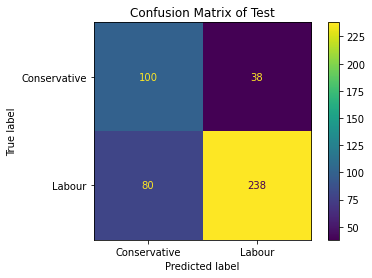

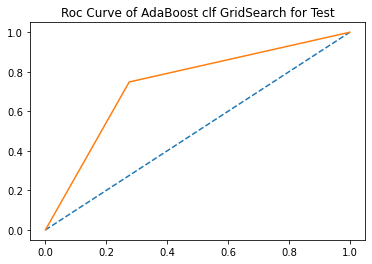

In [641]:
print_metric_score(adaboost_clf_tuned,X_test,y_test,'Test','AdaBoost clf GridSearch')

### Gradient Boost (tuned)

In [624]:
grid_param={'learning_rate':[0.0001,0.01,0.1],
            'n_estimators': [100,300,500,1000],
            'min_samples_split':[30,50,70],
            'min_samples_leaf':[5,10,15],
           'max_features':['auto','sqrt','log2']}
grid_search=GridSearchCV(estimator=GradientBoostingClassifier(),param_grid=grid_param,cv=5,scoring=scorer,verbose=2 )
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, ma

[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=10, min_samples_split=3

[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.0001, max_features=auto, min_samples_leaf=15, min_samples_split=3

[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.6s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_es

[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=10, min_samples_sp

[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=sqrt, min_samples_leaf=15, min_samples_spl

[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_est

[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=10, min_samples_split=5

[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.0001, max_features=log2, min_samples_leaf=15, min_samples_split=5

[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=5, min_samples_split=50, n_estimators=1000

[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=10, min_samples_split=70, n_estimato

[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.01, max_features=auto, min_samples_leaf=15, min_samples_split=70, n_estimators=

[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=5, min_samples_split=70, n_estimators=500; tot

[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=10, min_samples_split=70, n_estimator

[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=5, min_samples_split=30, n_estimato

[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=10, min_samples_split=30, n_estimators=

[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=

[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=5, min_samples_split=30, n_estimators=500; total time=

[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.5s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=10, min_samples_split=30, n_estimators=1000

[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=30, n_estimators=1000; total time=   1.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=auto, min_samples_leaf=15, min_samples_split=50, n_estimators=100; 

[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.1s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=5, min_samples_split=50, n_estimators=500; total time=

[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=10, min_samples_split=50, n_estimators=1000; t

[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=50, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=sqrt, min_samples_leaf=15, min_samples_split=70, n_estimators=100

[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=50, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=100; total time=   0.0s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=5, min_samples_split=70, n_estimators=300; total time

[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=10, min_samples_split=70, n_estimators=500; tot

[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=500; total time=   0.3s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.8s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; total time=   0.7s
[CV] END learning_rate=0.1, max_features=log2, min_samples_leaf=15, min_samples_split=70, n_estimators=1000; 

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.0001, 0.01, 0.1],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [30, 50, 70],
                         'n_estimators': [100, 300, 500, 1000]},
             scoring=make_scorer(precision_score), verbose=2)

In [625]:
grad_boost_tuned=grid_search.best_estimator_

In [626]:
grad_boost_tuned.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(learning_rate=0.0001, max_features='auto',
                           min_samples_leaf=5, min_samples_split=30)>

Accuracy score : 0.6965127238454288
              precision    recall  f1-score   support

Conservative       0.00      0.00      0.00       322
      Labour       0.70      1.00      0.82       739

    accuracy                           0.70      1061
   macro avg       0.35      0.50      0.41      1061
weighted avg       0.49      0.70      0.57      1061




Area Under the curve : 0.8576345405491725


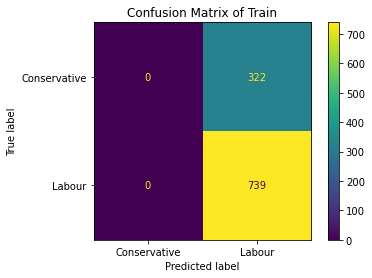

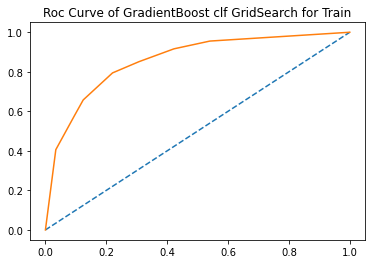

In [627]:
print_metric_score(grad_boost_tuned,X_train,y_train,'Train','GradientBoost clf GridSearch')

Accuracy score : 0.6973684210526315
              precision    recall  f1-score   support

Conservative       0.00      0.00      0.00       138
      Labour       0.70      1.00      0.82       318

    accuracy                           0.70       456
   macro avg       0.35      0.50      0.41       456
weighted avg       0.49      0.70      0.57       456




Area Under the curve : 0.8870431136632942


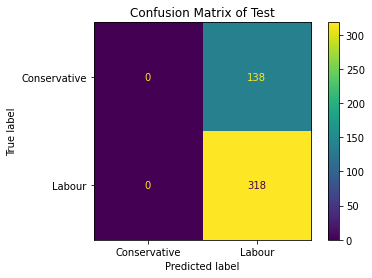

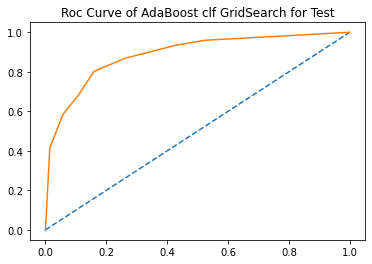

In [628]:
print_metric_score(grad_boost_tuned,X_test,y_test,'Test','AdaBoost clf GridSearch')

In [629]:
models=[log_clf_tuned,lda_clf_tuned,NB_clf_tuned,knn_clf_tuned,rforest_clf_tuned,adaboost_clf_tuned,grad_boost_tuned]



acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
auc_train=[]
auc_test=[]

for x in models:
    
    if(x==knn_clf):
        j=get_metric_score(x,X_train_scaled,X_test_scaled,y_train,y_test)
    else:
        j=get_metric_score(x,X_train,X_test,y_train,y_test)
    
    acc_train.append(np.round(j[0],3))
    acc_test.append(np.round(j[1],3))
    precision_train.append(np.round(j[2],3))
    precision_test.append(np.round(j[3],3))
    recall_train.append(np.round(j[4],3))
    recall_test.append(np.round(j[5],3))
    auc_train.append(np.round(j[6],3))
    auc_test.append(np.round(j[7],3))
    
    
    
    

GridSearch_frame = pd.DataFrame({'Model':['log_clf_tuned','lda_clf_tuned','NB_clf_tuned','knn_clf_tuned',
                                          'rforest_clf_tuned','adaboost_clf_tuned','grad_boost_tuned'],
                                 'Train_Accuracy': acc_train,
                                 'Test_Accuracy': acc_test,
                                 'Train_Recall':recall_train,
                                 'Test_Recall':recall_test,
                                 'Train_Precision':precision_train,
                                 'Test_Precision':precision_test,
                                'Train_AUC':auc_train,
                                'Test_AUC':auc_test}) 
GridSearch_frame

Model  Train_Accuracy  Test_Accuracy  ...  Test_Precision  Train_AUC  Test_AUC
0       log_clf_tuned           0.813          0.829  ...           0.683      0.878     0.914
1       lda_clf_tuned           0.823          0.853  ...           0.798      0.877     0.914
2        NB_clf_tuned           0.807          0.851  ...           0.818      0.854     0.895
3       knn_clf_tuned           0.555          0.586  ...           0.338      0.510     0.556
4   rforest_clf_tuned           0.826          0.842  ...           0.830      0.888     0.910
5  adaboost_clf_tuned           0.734          0.741  ...           0.556      0.742     0.737
6    grad_boost_tuned           0.697          0.697  ...           0.000      0.858     0.887

[7 rows x 9 columns]